# Chapter 10. Working with data

## 10.1 Exploring your data

### Exploring one-dimensional data

In [1]:
from typing import List, Dict
from collections import Counter
import math 
import matplotlib.pyplot as plt 

def bucketize(point: float, bucket_size: float) -> float:
    '''Floor the point to the next lower multiple of bucket_size'''
    return bucket_size * math.floor(point / bucket_size)

def make_histogram(points: List[float], bucket_size: float) -> Dict[float, int]:
    '''Buckets the points and counts how many in each bucket'''
    return Counter(bucketize(point, bucket_size) for point in points)

def plot_histogram(points: List[float], bucket_size: float, title: str = ""):
    histogram = make_histogram(points, bucket_size)
    plt.bar(histogram.keys(), histogram.values(), width = bucket_size)
    plt.title(title)

In [2]:
import random 

def normal_cdf(x: float, mu: float = 0, sigma: float = 1) -> float:
    return (1 + math.erf((x - mu) / math.sqrt(2) / sigma)) / 2

def inverse_normal_cdf(p: float,
                       mu: float = 0,
                       sigma: float = 1,
                       tolerance: float = 0.00001) -> float:
    """Find approximate inverse using binary search"""

    # if not standard, compute standard and rescale
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)

    low_z = -10.0                      # normal_cdf(-10) is (very close to) 0
    hi_z  =  10.0                      # normal_cdf(10)  is (very close to) 1
    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2     # Consider the midpoint
        mid_p = normal_cdf(mid_z)      # and the cdf's value there
        if mid_p < p:
            low_z = mid_z              # Midpoint too low, search above it
        else:
            hi_z = mid_z               # Midpoint too high, search below it

    return mid_z


In [4]:
random.seed(0)

uniform = [200 * random.random() - 100 for _ in range(10000)]
normal = [57 * inverse_normal_cdf(random.random())
          for _ in range(10000)]

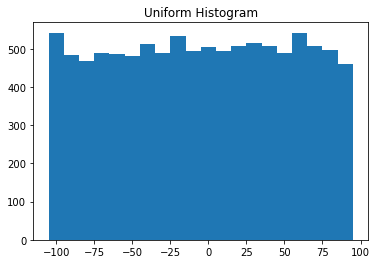

In [5]:
plot_histogram(uniform, 10, "Uniform Histogram")

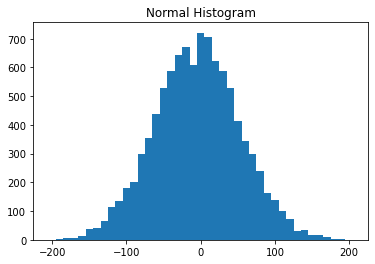

In [7]:
plot_histogram(normal, 10, "Normal Histogram")

### Two dimensions

In [8]:
def random_normal() -> float:
    '''Returns a random draw from a standard normal distribution'''
    return inverse_normal_cdf(random.random())

xs = [random_normal() for _ in range(1000)]
ys1 = [x + random_normal() / 2 for x in xs]
ys2 = [-x + random_normal() / 2 for x in xs]

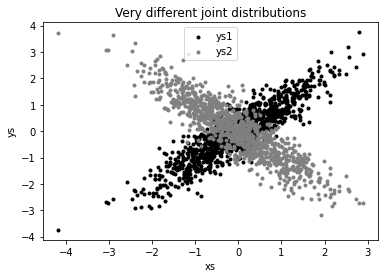

In [10]:
plt.scatter(xs, ys1, marker = '.', color = 'black', label = 'ys1')
plt.scatter(xs, ys2, marker = '.', color = 'gray', label = 'ys2')
plt.xlabel('xs')
plt.ylabel('ys')
plt.legend(loc = 9)
plt.title('Very different joint distributions')
plt.show()

In [22]:
from typing import List
Vector = List[float]

def dot(v: Vector, w: Vector) -> float:
    """Computes v_1 * w_1 + ... + v_n * w_n"""
    assert len(v) == len(w), "vectors must be same length"

    return sum(v_i * w_i for v_i, w_i in zip(v, w))

def covariance(xs: List[float], ys: List[float]) -> float:
    assert len(xs) == len(ys), "xs and ys must have same number of elements"

    return dot(de_mean(xs), de_mean(ys)) / (len(xs) - 1)


def correlation(xs: List[float], ys: List[float]) -> float:
    """Measures how much xs and ys vary in tandem about their means"""
    stdev_x = standard_deviation(xs)
    stdev_y = standard_deviation(ys)
    if stdev_x > 0 and stdev_y > 0:
        return covariance(xs, ys) / stdev_x / stdev_y
    else:
        return 0    # if no variation, correlation is zero
    
def de_mean(xs: List[float]) -> List[float]:
    """Translate xs by subtracting its mean (so the result has mean 0)"""
    x_bar = mean(xs)
    return [x - x_bar for x in xs]

def variance(xs: List[float]) -> float:
    """Almost the average squared deviation from the mean"""
    assert len(xs) >= 2, "variance requires at least two elements"

    n = len(xs)
    deviations = de_mean(xs)
    return sum_of_squares(deviations) / (n - 1)


import math

def standard_deviation(xs: List[float]) -> float:
    """The standard deviation is the square root of the variance"""
    return math.sqrt(variance(xs))

def mean(xs: List[float]) -> float:
    return sum(xs) / len(xs)

def sum_of_squares(v: Vector) -> float:
    """Returns v_1 * v_1 + ... + v_n * v_n"""
    return dot(v, v)

In [23]:
print(correlation(xs, ys1))

0.9010493686379609


In [24]:
print(correlation(xs, ys2))

-0.8920981526880033


### Many dimensions

In [26]:
from typing import Callable

Matrix = List[List[float]]

def make_matrix(num_rows: int,
                num_cols: int,
                entry_fn: Callable[[int, int], float]) -> Matrix:
    """
    Returns a num_rows x num_cols matrix
    whose (i,j)-th entry is entry_fn(i, j)
    """
    return [[entry_fn(i, j)             # given i, create a list
             for j in range(num_cols)]  #   [entry_fn(i, 0), ... ]
            for i in range(num_rows)]   # create one list for each i


In [27]:
def correlation_matrix(data: List[Vector]) -> Matrix:
    '''Returns the len(data) x len(data) matrix whose (i, j)-th entry is the correlation between data[i] and data[j]'''
    def correlation_ij(i: int, j: int) -> float:
        return correlation(data[i], data[j])
    return make_matrix(len(data), len(data), correlation_ij)

Scatterplot matrix

In [33]:
# corr_data is a list of four 100-d vectors
num_points = 100

def random_row() -> List[float]:
    row = [0.0, 0, 0, 0]
    row[0] = random_normal()
    row[1] = -5 * row[0] + random_normal()
    row[2] = row[0] + row[1] + 5 * random_normal()
    row[3] = 6 if row[2] > -2 else 0
    return row

random.seed(0)
 # each row has 4 points, but really we want the columns
corr_rows = [random_row() for _ in range(num_points)]

corr_data = [list(col) for col in zip(*corr_rows)]

In [38]:
len(corr_data)

4

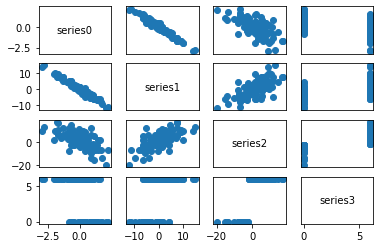

In [39]:
num_vectors = len(corr_data)

fig, ax = plt.subplots(num_vectors, num_vectors)

for i in range(num_vectors):
    for j in range(num_vectors):
        
        # Scatter column_j on the x-axis vs column_i on the y_axis
        if i != j:
            ax[i][j].scatter(corr_data[j], corr_data[i])
        # unless i == j, in which case show the series name 
        else:
            ax[i][j].annotate("series" + str(i), (0.5, 0.5),
                              xycoords = 'axes fraction',
                              ha = 'center',
                              va = 'center')
        
        # Then hide axis labels except left and bottom charts 
        if i < num_vectors -1: 
            ax[i][j].xaxis.set_visible(False)
        if j > 0:
            ax[i][j].yaxis.set_visible(False)
# Fix the bottom-right and top-left axis labels, which are wrong because their charts only have text in them 
ax[-1][-1].set_xlim(ax[0][-1].get_xlim())
ax[0][0].set_ylim(ax[0][1].get_ylim())

plt.show()

## 10.2 Using NamedTuples

A larger issue is that accessing things by dict key is error-prone.

There’s no helpful way to annotate dictionaries-as-data that have lots of different value types. So we also lose the power of type hints.

In [40]:
import datetime 

stock_price = {'closing_price': 102.06,
               'date': datetime.date(2014, 8, 29),
               'sumbol': 'AAPL'}

In [42]:
from collections import namedtuple

StockPrice = namedtuple('StockPrice', ['symbol', 'date', 'closing_price'])

price = StockPrice('MSFT', datetime.date(2018, 12, 14), 106.03)
price

StockPrice(symbol='MSFT', date=datetime.date(2018, 12, 14), closing_price=106.03)

In [43]:
assert price.symbol == 'MSFT'
assert price.closing_price == 106.03

Like regular tuples, namedtuples are immutable, which means that you can’t modify their values once they’re created

In [44]:
from typing import NamedTuple

class StockPrice(NamedTuple):
    symbol: str
    date: datetime.date
    closing_price: float
    
    def is_high_tech(self) -> bool:
        '''It is a class, so we can add methods too'''
        return self.symbol in ['MSFT', 'GOOG', 'FB', 'AMZN', 'AAPL']

price = StockPrice('MSFT', datetime.date(2018, 12, 14), 106.03)

assert price.symbol == 'MSFT'
assert price.closing_price == 106.03
assert price.is_high_tech()

## 10.3 Dataclasses

Dataclasses are a mutable version of NamedTuple. NamedTuples represent their data compactly as tuples, whereas dataclasses are regular python classes that simply generate some methods for you automatically

In [59]:
from dataclasses import dataclass

@dataclass
class StockPrice2:
    symbol: str
    date: datetime.date
    closing_price: float
    
    def is_high_tech(self) -> bool:
        '''It is a class, so we can add methods too'''
        return self.symbol in ['MSFT', 'GOOG', 'FB', 'AMZN', 'AAPL']
price2 = StockPrice2('MSFT', datetime.date(2018, 12, 14), 106.03)

assert price2.symbol == 'MSFT'
assert price2.closing_price == 106.03
assert price2.is_high_tech()

The big difference is that we can modify a dataclass instance's value. If we tried to modify a field of the NamedTuple version, we’d get an AttributeError

In [60]:
# Stock split 
price2.closing_price /= 2
price2.closing_price

53.015

In [63]:
price2.cosing_price = 75
price2.cosing_price

75

## 10.4 Cleaning and munging

In [68]:
from dateutil.parser import parse

def parse_row(row: List[str]) -> StockPrice:
    symbol, date, closing_price = row
    return StockPrice(symbol = symbol,
                      date = parse(date).date(),
                      closing_price = float(closing_price))

stock = parse_row(['MSFT', '2018-12-14', '106.03'])

assert stock.symbol == 'MSFT'
assert stock.date == datetime.date(2018, 12, 14)
assert stock.closing_price == 106.03

In [73]:
from typing import Optional 
import re

def try_parse_row(row: List[str]) -> Optional[StockPrice]:
    symbol, date_, closing_price_ = row
    
    # Stock symbol should be all capital letters 
    if not re.match(r"^[A-Z]+$", symbol):
        return None
    try:
        date = parse(date_).date()
    except ValueError:
        return None
    try: 
        closing_price = float(closing_price_)
    except ValueError:
        return None
    
    return StockPrice(symbol, date, closing_price)


assert try_parse_row(['MSFT0', '2018-12-14', '106.03']) is None
assert try_parse_row(['MSFT', '2018-12--14', '106.03']) is None
assert try_parse_row(['MSFT', '2018-12-14', 'x']) is None

assert try_parse_row(['MSFT', '2018-12-14', '106.03']) == stock

In [ ]:
import csv

data: List[StockPrice] = []

with open('comma_delimited_stock_prices.csv') as f:
    reader = csv.reader(f)
    for row in reader:
        maybe_stock = try_parse_row(row)
        if maybe_stock is None:
            print(f"skipping invalid row: {row}")
        else:
            data.append(maybe_stock)

## 10.5 Manipulating data

In [74]:
data = [
    StockPrice(symbol = 'MSFT',
               date = datetime.date(2018, 12, 24),
               closing_price = 106.03)
]

In [76]:
data

[StockPrice(symbol='MSFT', date=datetime.date(2018, 12, 24), closing_price=106.03)]

Know the highest-ever closing price for AAPL
1. Restrict to AAPL rows 
2. Grab the closing_price from each row
3. Take the max of those prices

In [ ]:
max_aapl_price = max(stock_price.closing_price 
                     for stock_price in data
                     if stock_price.symbol == 'AAPL')

Know the highest-ever closing price for each stock in the dataset
1. Create a dict to keep track of highest prices, to use defaultdict that returns minus infinity for missing values, since any price will be greater than that 
2. Iterate over the data, updating it 

In [ ]:
from collections import defaultdict 

max_prices: Dict[str, float] = defaultdict(lambda: float('-inf'))
    
for sp in data:
    symbol, closing_price = sp.symbol, sp.closing_price
    if closing_price > max_prices[symbol]:
        max_prices[symbol] = closing_price

The largest and smallest one-day percent changes in the dataset: price_today / price_yesterday - 1
1. Order the prices by date
2. Use zip to get (previous, current) pairs 
3. Turn the pairs into new percent change rows

In [ ]:
from typing import List 
from collections import defaultdict 

# Collect the prices by symbol 

price: Dict[str, List[StockPrice]] = defaultdict(list)

for sp in data:
    prices[sp.symbol].apend(sp)

# Order the prices by date 
prices = {symbol: sorted(symbol_prices)
          for symbol, symbol_prices in price.items()}

def pct_change(yesterday: StockPrice, today: StockPrice) -> float:
    return today.closing_price / yesterday.closing_price - 1

class DailyChange(NamedTuple):
    symbol: str
    date: datetime.date
    pct_change: float
        
def day_over_day_changes(prices: List[StockPrice]) -> List[DailyChange]:
    """
    Assumes prices are for one stock and are in order
    """
    return [DailyChange(symbol=today.symbol,
                        date=today.date,
                        pct_change=pct_change(yesterday, today))
            for yesterday, today in zip(prices, prices[1:])]

all_changes = [change
               for symbol_prices in prices.values()
               for change in day_over_day_changes(symbol_prices)]

In [ ]:
max_change = max(all_changes, key=lambda change: change.pct_change)
# see e.g. http://news.cnet.com/2100-1001-202143.html
assert max_change.symbol == 'AAPL'
assert max_change.date == datetime.date(1997, 8, 6)
assert 0.33 < max_change.pct_change < 0.34

min_change = min(all_changes, key=lambda change: change.pct_change)
# see e.g. http://money.cnn.com/2000/09/29/markets/techwrap/
assert min_change.symbol == 'AAPL'
assert min_change.date == datetime.date(2000, 9, 29)
assert -0.52 < min_change.pct_change < -0.51

In [ ]:
changes_by_month: List[DailyChange] = {month: [] for month in range(1, 13)}
    
for change in all_changes:
    changes_by_month[change.date.month].append(change)

    avg_daily_change = {
        month: sum(change.pct_change for change in changes) / len(changes)
        for month, changes in changes_by_month.items()
}
    
# October is the best month
assert avg_daily_change[10] == max(avg_daily_change.values())

## 10.6 Rescaling

In [80]:
def subtract(v: Vector, w: Vector) -> Vector:
    """Subtracts corresponding elements"""
    assert len(v) == len(w), "vectors must be the same length"

    return [v_i - w_i for v_i, w_i in zip(v, w)]

def squared_distance(v: Vector, w: Vector) -> float:
    """Computes (v_1 - w_1) ** 2 + ... + (v_n - w_n) ** 2"""
    return sum_of_squares(subtract(v, w))

def distance(v: Vector, w: Vector) -> float:
    """Computes the distance between v and w"""
    return math.sqrt(squared_distance(v, w))

In [81]:
a_to_b = distance([63, 150], [67, 160]) # 10.77
a_to_c = distance([63, 150], [70, 171]) # 22.14
b_to_c = distance([67, 160], [70, 171]) # 11.40

In [82]:
a_to_b = distance([160, 150], [170.2, 160]) # 14.28
a_to_c = distance([160, 150], [177.8, 171]) # 27.53
b_to_c = distance([170.2, 160], [177.8, 171]) # 13.37

In [85]:
from typing import Tuple

def scalar_multiply(c: float, v: Vector) -> Vector:
    """Multiplies every element by c"""
    return [c * v_i for v_i in v]

assert scalar_multiply(2, [1, 2, 3]) == [2, 4, 6]

def vector_mean(vectors: List[Vector]) -> Vector:
    """Computes the element-wise average"""
    n = len(vectors)
    return scalar_multiply(1/n, vector_sum(vectors))

def vector_sum(vectors: List[Vector]) -> Vector:
    """Sums all corresponding elements"""
    # Check that vectors is not empty
    assert vectors, "no vectors provided!"

    # Check the vectors are all the same size
    num_elements = len(vectors[0])
    assert all(len(v) == num_elements for v in vectors), "different sizes!"

    # the i-th element of the result is the sum of every vector[i]
    return [sum(vector[i] for vector in vectors)
            for i in range(num_elements)]

In [86]:
def scale(data: List[Vector]) -> Tuple[Vector, Vector]:
    """returns the mean and standard deviation for each position"""
    dim = len(data[0])
    means = vector_mean(data)
    stdevs = [standard_deviation([vector[i] for vector in data])
              for i in range(dim)]
    return means, stdevs

vectors = [[-3, -1, 1], [-1, 0, 1], [1, 1, 1]]
means, stdevs = scale(vectors)
assert means == [-1, 0, 1]
assert stdevs == [2, 1, 0]

In [87]:
def rescale(data: List[Vector]) -> List[Vector]:
    """
    Rescales the input data so that each position has
    mean 0 and standard deviation 1. (Leaves a position
    as is if its standard deviation is 0.)
    """
    dim = len(data[0])
    means, stdevs = scale(data)
    
    # Make a copy of each vector
    rescaled = [v[:] for v in data]
    for v in rescaled:
        for i in range(dim):
            if stdevs[i] > 0:
                v[i] = (v[i] - means[i]) / stdevs[i]
    return rescaled

In [88]:
means, stdevs = scale(rescale(vectors))
assert means == [0, 0, 1]
assert stdevs == [1, 1, 0]

## 10.7 An aside: tqdm

In [91]:
import tqdm

for i in tqdm.tqdm(range(100)):
    _ = [random.random() for _ in range(1000000)]

100%|██████████| 100/100 [00:10<00:00,  9.65it/s]


In particular, it shows you what fraction of your loop is done (though it can’t do this if you use a generator), how long it’s been running, and how long it expects to run.

In [92]:
for i in tqdm.trange(100):
    _ = [random.random() for _ in range(1000000)]

100%|██████████| 100/100 [00:09<00:00, 10.69it/s]


In [ ]:
from typing import List
def primes_up_to(n: int) -> List[int]:
    primes = [2]
    
    with tqdm.trange(3, n) as t:
        for i in t:
            # i is prime if no smaller prime divides it
            i_is_prime = not any(i % p == 0 for p in primes)
            if i_is_prime:
                primes.append(i)
            t.set_description(f"{len(primes)} primes")
    return primes

my_primes = primes_up_to(100_000)

## 10.8 Dimensionality reduction

In [96]:
def de_mean(data: List[Vector]) -> List[Vector]:
    """Recenters the data to have mean 0 in every dimension"""
    mean = vector_mean(data)
    return [subtract(vector, mean) for vector in data]

In [97]:
def magnitude(v: Vector) -> float:
    """Returns the magnitude (or length) of v"""
    return math.sqrt(sum_of_squares(v))   # math.sqrt is square root function

def direction(w: Vector) -> Vector:
    mag = magnitude(w)
    return [w_i / mag for w_i in w]

In [98]:
def directional_variance(data: List[Vector], w: Vector) -> float:
    """
    Returns the variance of x in the direction of w
    """
    w_dir = direction(w)
    return sum(dot(v, w_dir) ** 2 for v in data)

In [99]:
def directional_variance_gradient(data: List[Vector], w: Vector) -> Vector:
    """
    The gradient of directional variance with respect to w
    """
    w_dir = direction(w)
    return [sum(2 * dot(v, w_dir) * v[i] for v in data)
            for i in range(len(w))]

In [100]:
def gradient_step(v: Vector, gradient: Vector, step_size: float) -> Vector:
    """Moves `step_size` in the `gradient` direction from `v`"""
    assert len(v) == len(gradient)
    step = scalar_multiply(step_size, gradient)
    return add(v, step)

In [101]:
def first_principal_component(data: List[Vector],
                              n: int = 100,
                              step_size: float = 0.1) -> Vector:
    # Start with a random guess
    guess = [1.0 for _ in data[0]]
    
    with tqdm.trange(n) as t:
        for _ in t:
            dv = directional_variance(data, guess)
            gradient = directional_variance_gradient(data, guess)
            guess = gradient_step(guess, gradient, step_size)
            t.set_description(f"dv: {dv:.3f}")
    return direction(guess)

In [102]:
def project(v: Vector, w: Vector) -> Vector:
    """return the projection of v onto the direction w"""
    projection_length = dot(v, w)
    return scalar_multiply(projection_length, w)

In [103]:
def remove_projection_from_vector(v: Vector, w: Vector) -> Vector:
    """projects v onto w and subtracts the result from v"""
    return subtract(v, project(v, w))

def remove_projection(data: List[Vector], w: Vector) -> List[Vector]:
    return [remove_projection_from_vector(v, w) for v in data]

In [104]:
def pca(data: List[Vector], num_components: int) -> List[Vector]:
    components: List[Vector] = []
    for _ in range(num_components):
        component = first_principal_component(data)
        components.append(component)
        data = remove_projection(data, component)
    return components

In [ ]:
def transform_vector(v: Vector, components: List[Vector]) -> Vector:
    return [dot(v, w) for w in components]
def transform(data: List[Vector], components: List[Vector]) -> List[Vector]:
    return [transform_vector(v, components) for v in data]

## 10.9 For further exploration

pandas and scikit-learn